# Overlap en imágenes reales


In [2]:
%reload_ext autoreload
%autoreload 2
import logging
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pylab as plt

from fpmsample.simicro import SimMicroscope, NoiseModel
from phaseopt import data
from phaseopt.containers import Options, ResultsContainer
# from phaseopt.phaseopt import solve
from phasemath import math as pmath

LOG = logging.getLogger('Main')
LOG.setLevel(level=logging.INFO)  # to send all records to cuteLOG
LOG.addHandler(logging.handlers.SocketHandler('127.0.0.1', 19996))

def simulate(index=None, led_gap=None):
    """ Simulates a given magnitude and phase image.
    """
    noise_model = NoiseModel(offset=[.0, .0], euler_triplet=[.0, .0, .0],
                             noise_mask=np.zeros((32, 32)), sigmam=[.0, .0])
    cfg = data.cfg_load()
    sm = SimMicroscope(noise_model=noise_model, cfg=cfg, image_index=index,
                       load_image_mode='sequential')
    sm.led_gap = led_gap
    sm.details()
    sm.generate_samples()
    return sm

def filter_image(mic, theta, phi):
    return pmath.pupil_filter(mic.complex_image, mic.na, mic.wlen, mic.ps_syn, mic.mk, theta=theta, phi=phi)

def interpolate(image, n):
    im_interp = np.zeros(np.array(image.shape)*n)
    im_interp[::n, ::n] = image
    return im_interp

En primer lugar, se parte de la imagen $s(x, y)$ y se la filtra con la pupila $p(x,y)$. Si $P_0(k_x, k_y)$ es la transformada de la pupila centrada, entonces una pupila corrida en $(k_1, k_2)$ es $P(k_x, k_y) = P_0(k_x-k_1, k_y-k_2)$ yn el plano imagen esto equivale a multiplicar la pupila por una fase $p(x,y)=p_0(x,y) e^{i (k_1 x, k_2 y)}$.

Aún sin perder la información de fase, tomar una foto con una pupila corrida y quedarse solamente con el fragmento correspondiente a la misma se ve como una pupila centrada en el origen en donde la transformada se corre en la cantidad dada por $(k_1, k2)$, despues de todo la fase de la pupila bien podría agregarse a $S_f(k_x, k_y) = S(k_x-k_1, k_y-k_2) P_0(k_x, k_y)$.
Nota: Dado un par de ángulos $\theta$ y $\varphi$, el corrimiento en k corresponde a $(k_1, k_2) = \frac{2\pi}{\lambda} \sin{\varphi} (\cos{\theta}, \sin{\theta})$ que en píxeles  es $n_{k_1, k_2} = \frac{n p_s}{\lambda} \sin{\varphi} (\cos{\theta}, \sin{\theta})$, donde $n$ es el tamaño de lado de la imagen y $p_s$ el tamaño de píxel real.

El corrimiento es de 5 pixeles.


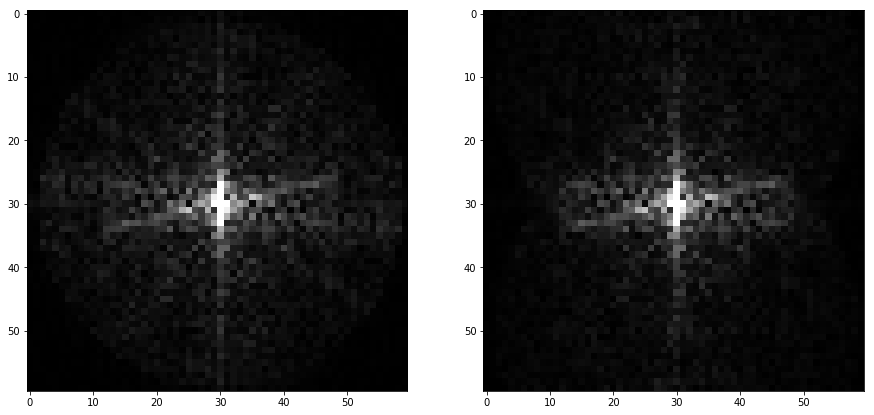

In [3]:
mic = simulate(index=3, led_gap=5)
im1 = np.abs(filter_image(mic, theta=0, phi=0))
im2 = np.abs(filter_image(mic, theta=0, phi=8))
nk = np.floor(mic.ps*mic.patch/mic.wlen*np.sin(np.radians(2)))
print('El corrimiento es de %i pixeles.'%nk)
fftim1 = fftshift(fft2(im1))
fftim2 = fftshift(fft2(im2))
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(np.abs(fftim1), cmap='gray', vmax=np.abs(fftim1).max()/20)
axes[1].imshow(np.abs(fftim2), cmap='gray', vmax=np.abs(fftim2).max()/20)
plt.show()

La cámara captura la intensidad del campo incidente $I = |s_f(x,y)|^2$, con lo que en el espacio transformado se tiene una convolución de la pupila consigo misma. Para introducir en el algoritmo de reconstrucción, típicamente uno toma la raíz de las intensidades para tener objetos proporcionales a la amplitud del campo. El tema es que estas nuevas imágenes son un nuevo producto de convolución. La idea, en forma más ordenada es la siguiente:

1) Por un lado tengo el valor deseado, $|S(k_x, k_y)|$ y su imagen real asociada $|s(x, y)|$

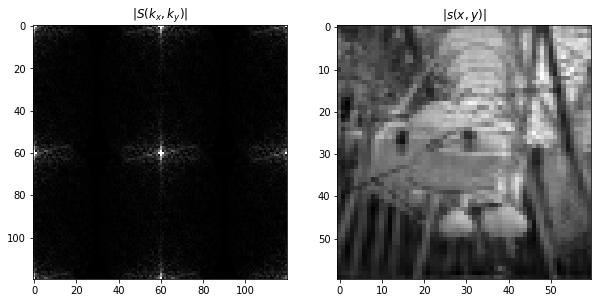

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
abss = np.abs(filter_image(mic, theta=0, phi=8))
abss_interp= interpolate(abss, 2)
fftabss = fftshift(fft2(abss_interp))
axes[0].imshow(np.abs(fftabss), cmap='gray', vmax=np.abs(fftabss).max()/10)
axes[1].imshow(np.abs(abss), cmap='gray')
axes[0].set_title('$|S(k_x, k_y)|$')
axes[1].set_title('$|s(x, y)|$')
plt.show()

2) En la cámara, lo que se adquiere es una intensidad $I = |s_f(x,y)|^2$, que se corresponderá con $S_I(k_x, k_y) = S(k_x, k_y) \circledast \bar{S}(k_x, k_y)$.

Para pupilas simétricas e imágenes simétricas, la convolución cae sobre el círculo original.

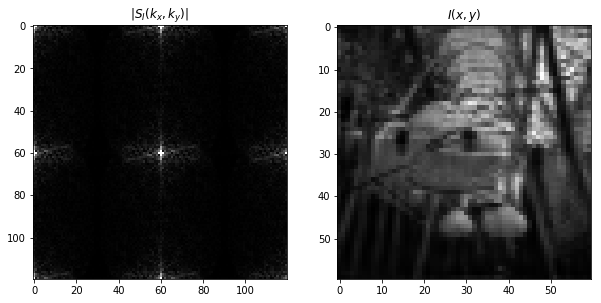

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sint = np.abs(filter_image(mic, theta=0, phi=8))**2
sint_interp = interpolate(abss, 2)
fftsint = fftshift(fft2(sint_interp))
axes[0].imshow(np.abs(fftsint), cmap='gray', vmax=np.abs(fftsint).max()/10)
axes[1].imshow(np.abs(sint), cmap='gray')
axes[0].set_title('$|S_I(k_x, k_y)|$')
axes[1].set_title('$I(x, y)$')
plt.show()


3) En el algoritmo de reconstrucción se usa la raíz de la intensidad como estimador de la amplitud.

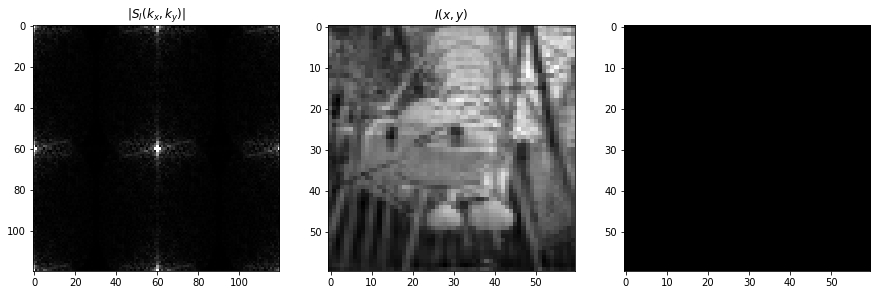

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
isqrt = np.sqrt(sint)
isqrt_interp = interpolate(isqrt, 2)
fftisqrt = fftshift(fft2(isqrt_interp))
axes[0].imshow(np.abs(fftisqrt), cmap='gray', vmax=np.abs(fftisqrt).max()/10)
axes[1].imshow(np.abs(isqrt), cmap='gray')
axes[0].set_title('$|S_I(k_x, k_y)|$')
axes[1].set_title('$I(x, y)$')
axes[2].imshow(np.abs(isqrt)-np.abs(abss), cmap='gray')
plt.show()

Si ahora quiero comparar dos pupilas aledañas, primero hay que tener en cuenta que el efecto de la correlación da lugar a patrones con el máximo central y simétricos, pero cercanos a cero en la zona de solapamiento. Al aumentar el ángulo $\varphi$ se pierde totalmente el contraste porque el espectro es casi nulo.

37.0 0.0
0.024328353707343705


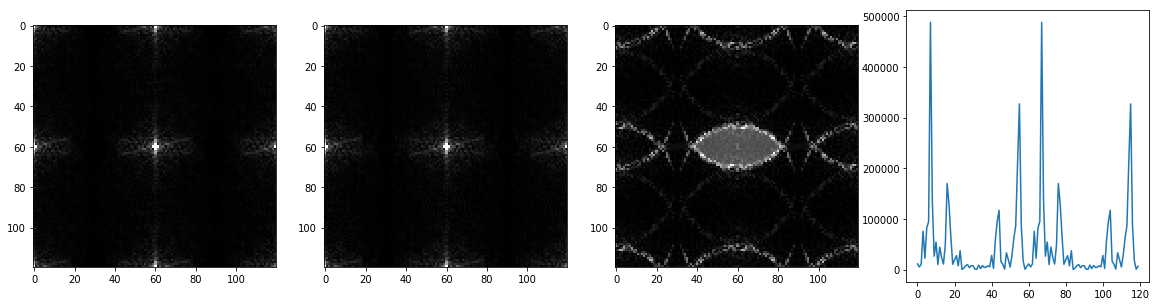

In [7]:
phi1, phi2 = [8, 7]
theta1, theta2 = [0, 0]
im1 = np.abs(filter_image(mic, theta=theta1, phi=phi1))
im2 = np.abs(filter_image(mic, theta=theta2, phi=phi2))

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fftim1 = fftshift(fft2(interpolate(im1, 2)))
fftim2 = fftshift(fft2(interpolate(im2, 2)))
axes[0].imshow(np.abs(fftim1), cmap='gray', vmax=np.abs(fftim1).max()/10)
axes[1].imshow(np.abs(fftim2), cmap='gray', vmax=np.abs(fftim2).max()/10)
fftdiff = np.abs(np.abs(fftim1)-np.abs(fftim2))
axes[2].imshow(fftdiff, cmap='gray', vmax=fftdiff.max())
axes[3].plot(fftdiff[:,45])

# Calculo las pupilas overlapeadas
def nk(mic, theta, phi):
    a = mic.ps*mic.patch/mic.wlen*np.sin(np.radians(phi))
    kx = a*np.sin(np.radians(theta))
    ky = a*np.cos(np.radians(theta))
    return np.floor(ky), np.floor(kx)

ky1, kx1 = nk(mic, theta1, phi1)
ky2, kx2 = nk(mic, theta2, phi2)
kx = kx2+kx1
ky = ky2+ky1
print(ky, kx)
n = mic.patch*2
yy, xx = np.ogrid[-n//2:n//2, -n//2:n//2]
ol1 = ((xx-kx//2)**2+(yy-ky//2)**2) < mic.no**2
ol2 =  ((xx+kx//2)**2+(yy+ky//2)**2) < mic.no**2
ol = ol1 & ol2
axes[2].imshow(ol, cmap='gray', alpha=.3)

total = sum(np.abs(fftim1[ol2])+np.abs(fftim1[ol1]))
print(sum(fftdiff[ol]/total))
plt.show()

In [8]:
def overlap_quantities(im1, angles1, im2, angles2):
    fftim1 = fftshift(fft2(im1))
    fftim2 = fftshift(fft2(im2))
    theta1, phi1 = angles1
    theta2, phi2 = angles2
    # Calculo las pupilas overlapeadas
    def nk(mic, theta, phi):
        a = mic.ps*mic.patch/mic.wlen*np.sin(np.radians(phi))
        kx = a*np.sin(np.radians(theta))
        ky = a*np.cos(np.radians(theta))
        return np.floor(ky), np.floor(kx)

    ky1, kx1 = nk(mic, theta1, phi1)
    ky2, kx2 = nk(mic, theta2, phi2)
    kx = kx2+kx1
    ky = ky2+ky1

    n = mic.patch
    yy, xx = np.ogrid[-n//2:n//2, -n//2:n//2]
    ol1 = ((xx-kx//2)**2+(yy-ky//2)**2) < mic.no**2
    ol2 =  ((xx+kx//2)**2+(yy+ky//2)**2) < mic.no**2
    ol = ol1 & ol2
    fftdiff = np.abs(np.abs(fftim1)-np.abs(fftim2))
    fftsum = np.abs(np.abs(fftim1)+np.abs(fftim2))
    return sum(fftdiff[ol])/np.sum(fftsum), sum(fftsum[ol])/np.sum(fftsum)
phi1, phi2 = [6, 4]
theta1, theta2 = [0, 0]
im1 = np.abs(filter_image(mic, theta=theta1, phi=phi1))
im2 = np.abs(filter_image(mic, theta=theta2, phi=phi2))
overlap_quantities(im1, (theta1, phi1), im2, (theta2, phi2))

(0.025835131851538934, 0.7521427064355827)